In [102]:
import load_datasets as ld
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

In [148]:
data = ld.load_graph_dataset(name='PROTEINS_full', min_num_nodes=20, max_num_nodes=1000, node_attributes=False, graph_labels=True)

Loaded 1113 graphs for dataset PROTEINS_full


In [107]:
random.shuffle(data)
length = len(data)

# 60-20-20 split for train, valid, test data
train = data[:int(0.6*length)]
valid = data[:int(0.6*length):int(0.8*length)]
test = data[int(0.8*length):]

In [126]:
mat = np.random.rand(3, 3)
mat = (mat + mat.T)
mat = np.where(mat > 0.5, 1, 0)
x_idx = np.random.permutation(mat.shape[0])
print(mat)
print(mat[np.ix_(x_idx, x_idx)])

[[1 1 1]
 [1 1 1]
 [1 1 0]]
[[1 1 1]
 [1 0 1]
 [1 1 1]]


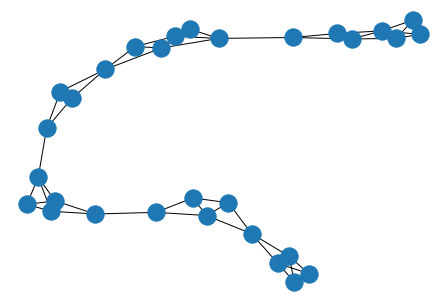

In [110]:
# pick a random element of data, then draw it
G = test[0]
nx.draw(G, with_labels=False)

In [182]:
def encode_adj_flexible(adj):
    '''
    return a flexible length of output
    note that here there is no loss when encoding/decoding an adj matrix
    :param adj: adj matrix
    :return:
    '''
    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]
    print(adj)
    adj_output = []
    input_start = 0
    for i in range(adj.shape[0]):
        input_end = i + 1
        adj_slice = adj[i, input_start:input_end]
        adj_output.append(adj_slice)
        print(adj_slice)
        non_zero = np.nonzero(adj_slice)[0]
        print("row index ", i, "slice: [", input_start, input_end,"], nonzero: ", non_zero)
        input_start = input_end-len(adj_slice)+np.amin(non_zero)

    return adj_output

In [85]:
def encode(adj):
    def split(x, idx: list):
        x_split = []
        start = 0
        for i in idx:
            x_split.append(x[start:i])
            start = i
        return x_split
        
    # keep the lower triangle of the matrix, remove elements which are not in the lower triangle
    adj = np.tril(adj, k=-1)
    split_indices = np.cumsum(np.arange(start=1, stop=adj.shape[0], step=1))
    adj = adj[np.tril(np.ones(adj.shape, dtype=bool), k=-1)]
    return split(adj, split_indices)
    

In [187]:
np.tril(np.ones((5,5)), k=-3)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.]])

In [190]:
mat = np.ones((5,5)) - np.identity(5) - np.tril(np.ones((5,5)), k=-3)
mat[2,1] = 0
mat

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0.]])

In [191]:
print(encode_adj_flexible(mat))
# print(encode(mat))

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 1. 1.]]
[1.]
row index  0 slice: [ 0 1 ], nonzero:  [0]
[1. 0.]
row index  1 slice: [ 0 2 ], nonzero:  [0]
[0. 1. 1.]
row index  2 slice: [ 0 3 ], nonzero:  [1 2]
[0. 1. 1.]
row index  3 slice: [ 1 4 ], nonzero:  [1 2]
[array([1.]), array([1., 0.]), array([0., 1., 1.]), array([0., 1., 1.])]


In [186]:
print(encode(mat))

[array([1.]), array([1., 1.]), array([1., 1., 1.]), array([1., 1., 1., 1.])]


In [99]:
G = nx.ladder_graph(5)
adj = np.array(nx.to_numpy_array(G))

In [100]:
print(encode_adj_flexible(adj))
print(encode(adj))

ValueError: zero-size array to reduction operation minimum which has no identity

In [127]:
def bfs_seq(G, start_id):
    '''
    get a bfs node sequence
    :param G:
    :param start_id:
    :return:
    '''
    dictionary = dict(nx.bfs_successors(G, start_id))
    start = [start_id]
    output = [start_id]
    while len(start) > 0:
        next = []
        while len(start) > 0:
            current = start.pop(0)
            neighbor = dictionary.get(current)
            if neighbor is not None:
                #### a wrong example, should not permute here!
                # shuffle(neighbor)
                next = next + neighbor
        output = output + next
        start = next
    return output

In [147]:
def bfs(G, start_id):
    # return a list containing the bfs sequence
    return list(nx.bfs_tree(G, start_id))

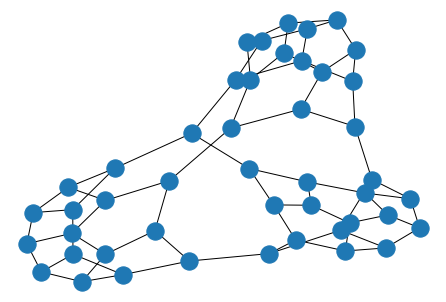

In [144]:
G = nx.tutte_graph()
nx.draw(G)

In [155]:
random.shuffle(data)
for graph in data:
    assert bfs(G, 0) == bfs_seq(G, 0)

In [156]:
def encode_adj(adj, max_prev_node=10, is_full = False):
    '''
    :param adj: n*n, rows means time step, while columns are input dimension
    :param max_degree: we want to keep row number, but truncate column numbers
    :return:
    '''
    if is_full:
        max_prev_node = adj.shape[0]-1

    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    # use max_prev_node to truncate
    # note: now adj is a (n-1)*(n-1) matrix
    adj_output = np.zeros((adj.shape[0], max_prev_node))
    for i in range(adj.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + input_start - input_end
        output_end = max_prev_node
        adj_output[i, output_start:output_end] = adj[i, input_start:input_end]
        adj_output[i,:] = adj_output[i,:][::-1] # reverse order

    return adj_output

In [164]:
def encode_basic(adj, M):
    matrix = np.tril(adj, k=-1)
    n = matrix.shape[0]
    matrix = matrix[1:n, 0:M]
    return matrix


In [171]:
a = bfs(G, 0)
g = nx.to_numpy_matrix(G)
a = g[np.ix_(a,a)]

In [172]:
encode_basic(a, 3)[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [173]:
encode_adj(a, max_prev_node=3)[:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])